In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count, when, skewness, min, max, expr, isnan

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection") \
    .getOrCreate()

# Загрузка данных
filename_data = 'the-reddit-covid-dataset-posts.csv'
df = spark.read.options(inferSchema='True', header='True', delimiter=',').csv(filename_data, mode='DROPMALFORMED')

# Определение колонок
string_columns = ['type', 'id', 'subreddit.id', 'subreddit.name', 'permalink', 'domain', 'url', 'selftext', 'title']
numeric_with_zeroes_columns = ['score']
numeric_without_zeroes_columns = ['created_utc']
boolean_columns = ['subreddit.nsfw']

# Переименование колонок с точками
df = df.withColumnRenamed('subreddit.id', 'subreddit_id') \
       .withColumnRenamed('subreddit.name', 'subreddit_name') \
       .withColumnRenamed('subreddit.nsfw', 'subreddit_nsfw')

# Обновление списков колонок
string_columns = ['type', 'id', 'subreddit_id', 'subreddit_name', 'permalink', 'domain', 'url', 'selftext', 'title']
boolean_columns = ['subreddit_nsfw']

# Проверка на наличие пропущенных значений
missing_values = {}
for column in df.columns:
    if column in string_columns:
        missing_count = df.filter(col(column).isNull()).count()
    elif column in numeric_with_zeroes_columns:
        missing_count = df.filter((col(column) == 0) | col(column).isNull()).count()
    elif column in numeric_without_zeroes_columns:
        missing_count = df.filter((col(column) == 0) | col(column).isNull() | isnan(col(column))).count()
    elif column in boolean_columns:
        missing_count = df.filter(col(column).isNull()).count()
    missing_values[column] = missing_count

print("Пропущенные значения:")
for column, missing_count in missing_values.items():
    print(f"{column}: {missing_count}")

# Удаление строк с пропущенными значениями в критически важных колонках
critical_columns = ['type', 'id', 'subreddit_id', 'subreddit_name', 'created_utc', 'title', 'score']
df_cleaned = df.dropna(subset=critical_columns)

# Удаление строк с аномальными нулевыми значениями в числовых колонках
for column in numeric_with_zeroes_columns + numeric_without_zeroes_columns:
    df_cleaned = df_cleaned.filter(col(column) != 0)

print(f'Количество строк после удаления пропущенных и аномальных нулевых значений: {df_cleaned.count()}')

# Определение и удаление выбросов с использованием метода Z-оценки
def remove_outliers_zscore(df, column, threshold=3):
    mean_val = df.agg(mean(col(column))).collect()[0][0]
    stddev_val = df.agg(stddev(col(column))).collect()[0][0]
    lower_bound = mean_val - threshold * stddev_val
    upper_bound = mean_val + threshold * stddev_val
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

for column in numeric_with_zeroes_columns + numeric_without_zeroes_columns:
    df_cleaned = remove_outliers_zscore(df_cleaned, column)

print(f'Количество строк после удаления выбросов: {df_cleaned.count()}')

# Расчет статистических показателей
def calculate_statistics(df, column):
    min_val = df.agg(min(col(column))).collect()[0][0]
    mean_val = df.agg(mean(col(column))).collect()[0][0]
    max_val = df.agg(max(col(column))).collect()[0][0]
    stddev_val = df.agg(stddev(col(column))).collect()[0][0]
    q1_val = df.approxQuantile(column, [0.25], 0.01)[0]
    median_val = df.approxQuantile(column, [0.5], 0.01)[0]
    q3_val = df.approxQuantile(column, [0.75], 0.01)[0]
    skewness_val = df.select(skewness(col(column))).collect()[0][0]
    return min_val, mean_val, max_val, stddev_val, q1_val, median_val, q3_val, skewness_val

for column in numeric_with_zeroes_columns + numeric_without_zeroes_columns:
    min_val, mean_val, max_val, stddev_val, q1_val, median_val, q3_val, skewness_val = calculate_statistics(df_cleaned, column)
    print(f"Статистические показатели для колонки '{column}':")
    print(f"Минимальное значение: {min_val}")
    print(f"Среднее значение: {mean_val}")
    print(f"Максимальное значение: {max_val}")
    print(f"Стандартное отклонение: {stddev_val}")
    print(f"Квартиль Q1: {q1_val}")
    print(f"Медиана: {median_val}")
    print(f"Квартиль Q3: {q3_val}")
    print(f"Коэффициент асимметрии: {skewness_val}")

# Визуализация данных
def plot_histogram(df, column):
    pandas_df = df.select(column).sample(fraction=0.1, seed=42).toPandas()  # Выборка 10% данных
    data = pandas_df[column]
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins='auto', color='blue')
    plt.title(f'Гистограмма распределения {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

numeric_columns = ['created_utc', 'score']
for column in numeric_columns:
    plot_histogram(df_cleaned, column)

# Обновленная функция для построения box plot
def plot_boxplot(df, column):
    # Вычисление основных статистических показателей с использованием Spark
    stats = df.selectExpr(
        f'percentile_approx({column}, 0.25) as Q1',
        f'percentile_approx({column}, 0.5) as Median',
        f'percentile_approx({column}, 0.75) as Q3',
        f'min({column}) as Min',
        f'max({column}) as Max'
    ).collect()[0]

    # Извлечение значений
    Q1 = stats['Q1']
    Median = stats['Median']
    Q3 = stats['Q3']
    Min = stats['Min']
    Max = stats['Max']

    # Вычисление межквартильного размаха (IQR)
    IQR = Q3 - Q1

    # Вычисление нижней и верхней границ для выявления выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Преобразование PySpark DataFrame в Pandas DataFrame для дальнейшего анализа
    pandas_df = df.select(column).toPandas()

    # Создание списка выбросов
    outliers = pandas_df[(pandas_df[column] < lower_bound) | (pandas_df[column] > upper_bound)][column].tolist()

    # Создание нового рисунка с заданным размером
    plt.figure(figsize=(10, 6))

    # Построение ящичного графика
    plt.boxplot(pandas_df[column], vert=False)  # vert=False для горизонтального ящика

    # Установка заголовка графика с указанием названия столбца
    plt.title(f"Box plot of '{column}'")
    
    # Установка метки оси x с названием столбца
    plt.xlabel(column)
    
    # Отображение графика
    plt.show()

for column in numeric_columns:
    plot_boxplot(df_cleaned, column)

def plot_scatter(df, x_column, y_column):
    pandas_df = df.select(x_column, y_column).sample(fraction=0.1, seed=42).toPandas()  # Выборка 10% данных
    x_data = pandas_df[x_column]
    y_data = pandas_df[y_column]
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, alpha=0.5)
    plt.title(f'Диаграмма рассеяния {x_column} vs {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.grid(True)
    plt.show()

plot_scatter(df_cleaned, 'created_utc', 'score')

# Расчет и визуализация матрицы корреляций
assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
df_vector = assembler.transform(df_cleaned).select('features')
matrix = Correlation.corr(df_vector, 'features').head()[0]
corr_matrix = matrix.toArray()
sns.heatmap(corr_matrix, annot=True, xticklabels=numeric_columns, yticklabels=numeric_columns, cmap='Blues')
plt.title('Матрица корреляций')
plt.show()


Пропущенные значения:
type: 74
id: 1468097
subreddit_id: 1804442
subreddit_name: 2245366
subreddit_nsfw: 2424559
created_utc: 2512750
permalink: 2564182
domain: 2595425
url: 3742452
selftext: 6003146
title: 2930362
score: 3115298
Количество строк после удаления пропущенных и аномальных нулевых значений: 3999014
Количество строк после удаления выбросов: 3998570


IllegalArgumentException: requirement failed: Quantile calculation for column score with data type StringType is not supported.

In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection - Missing Values") \
    .getOrCreate()

# Загрузка данных
filename_data = 'the-reddit-covid-dataset-posts.csv'
df = spark.read.options(inferSchema='True', header='True', delimiter=',').csv(filename_data, mode='DROPMALFORMED')

# Определение колонок
string_columns = ['type', 'id', 'subreddit.id', 'subreddit.name', 'permalink', 'domain', 'url', 'selftext', 'title']
numeric_with_zeroes_columns = ['score']
numeric_without_zeroes_columns = ['created_utc']
boolean_columns = ['subreddit.nsfw']

# Переименование колонок с точками
df = df.withColumnRenamed('subreddit.id', 'subreddit_id') \
       .withColumnRenamed('subreddit.name', 'subreddit_name') \
       .withColumnRenamed('subreddit.nsfw', 'subreddit_nsfw')

# Обновление списков колонок
string_columns = ['type', 'id', 'subreddit_id', 'subreddit_name', 'permalink', 'domain', 'url', 'selftext', 'title']
boolean_columns = ['subreddit_nsfw']

# Проверка на наличие пропущенных значений
missing_values = {}
for column in df.columns:
    if column in string_columns:
        missing_count = df.filter(col(column).isNull()).count()
    elif column in numeric_with_zeroes_columns:
        missing_count = df.filter((col(column) == 0) | col(column).isNull()).count()
    elif column in numeric_without_zeroes_columns:
        missing_count = df.filter((col(column) == 0) | col(column).isNull() | isnan(col(column))).count()
    elif column in boolean_columns:
        missing_count = df.filter(col(column).isNull()).count()
    missing_values[column] = missing_count

print("Пропущенные значения:")
for column, missing_count in missing_values.items():
    print(f"{column}: {missing_count}")

# Удаление строк с пропущенными значениями в критически важных колонках
critical_columns = ['type', 'id', 'subreddit_id', 'subreddit_name', 'created_utc', 'title', 'score']
df_cleaned = df.dropna(subset=critical_columns)

# Удаление строк с аномальными нулевыми значениями в числовых колонках
for column in numeric_with_zeroes_columns + numeric_without_zeroes_columns:
    df_cleaned = df_cleaned.filter(col(column) != 0)

print(f'Количество строк после удаления пропущенных и аномальных нулевых значений: {df_cleaned.count()}')

# Сохранение промежуточного результата для дальнейших шагов
df_cleaned.write.mode('overwrite').parquet('cleaned_data.parquet')


Пропущенные значения:
type: 74
id: 1468097
subreddit_id: 1804442
subreddit_name: 2245366
subreddit_nsfw: 2424559
created_utc: 2512750
permalink: 2564182
domain: 2595425
url: 3742452
selftext: 6003146
title: 2930362
score: 3115298
Количество строк после удаления пропущенных и аномальных нулевых значений: 3999014


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection - Outliers Removal") \
    .getOrCreate()

# Загрузка очищенных данных
df_cleaned = spark.read.parquet('cleaned_data.parquet')

# Определение и удаление выбросов с использованием метода Z-оценки
def remove_outliers_zscore(df, column, threshold=3):
    mean_val = df.agg(mean(col(column))).collect()[0][0]
    stddev_val = df.agg(stddev(col(column))).collect()[0][0]
    lower_bound = mean_val - threshold * stddev_val
    upper_bound = mean_val + threshold * stddev_val
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

numeric_with_zeroes_columns = ['score']
numeric_without_zeroes_columns = ['created_utc']

for column in numeric_with_zeroes_columns + numeric_without_zeroes_columns:
    df_cleaned = remove_outliers_zscore(df_cleaned, column)

print(f'Количество строк после удаления выбросов: {df_cleaned.count()}')

# Сохранение промежуточного результата для дальнейших шагов
df_cleaned.write.mode('overwrite').parquet('cleaned_data_no_outliers.parquet')


Количество строк после удаления выбросов: 3989684


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, min, max, expr, skewness

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection - Statistics Calculation") \
    .getOrCreate()

# Загрузка очищенных данных без выбросов
df_cleaned = spark.read.parquet('cleaned_data_no_outliers.parquet')

# Определение колонок
numeric_with_zeroes_columns = ['score']
numeric_without_zeroes_columns = ['created_utc']

# Преобразование типов колонок в числовые
for column in numeric_with_zeroes_columns + numeric_without_zeroes_columns:
    df_cleaned = df_cleaned.withColumn(column, col(column).cast("double"))

# Расчет статистических показателей
def calculate_statistics(df, column):
    min_val = df.agg(min(col(column))).collect()[0][0]
    mean_val = df.agg(mean(col(column))).collect()[0][0]
    max_val = df.agg(max(col(column))).collect()[0][0]
    stddev_val = df.agg(stddev(col(column))).collect()[0][0]
    q1_val = df.approxQuantile(column, [0.25], 0.01)[0]
    median_val = df.approxQuantile(column, [0.5], 0.01)[0]
    q3_val = df.approxQuantile(column, [0.75], 0.01)[0]
    skewness_val = df.select(skewness(col(column))).collect()[0][0]
    return min_val, mean_val, max_val, stddev_val, q1_val, median_val, q3_val, skewness_val

# Вычисление и вывод статистических показателей для каждой числовой колонки
for column in numeric_with_zeroes_columns + numeric_without_zeroes_columns:
    min_val, mean_val, max_val, stddev_val, q1_val, median_val, q3_val, skewness_val = calculate_statistics(df_cleaned, column)
    print(f"Статистические показатели для колонки '{column}':")
    print(f"Минимальное значение: {min_val}")
    print(f"Среднее значение: {mean_val}")
    print(f"Максимальное значение: {max_val}")
    print(f"Стандартное отклонение: {stddev_val}")
    print(f"Квартиль Q1: {q1_val}")
    print(f"Медиана: {median_val}")
    print(f"Квартиль Q3: {q3_val}")
    print(f"Коэффициент асимметрии: {skewness_val}")


Статистические показатели для колонки 'score':
Минимальное значение: 1.0
Среднее значение: 21.657614237117524
Максимальное значение: 3936.0
Стандартное отклонение: 139.63783698145716
Квартиль Q1: 1.0
Медиана: 1.0
Квартиль Q3: 2.0
Коэффициент асимметрии: 15.099092144962134
Статистические показатели для колонки 'created_utc':
Минимальное значение: 1581433858.0
Среднее значение: 1605355499.4514163
Максимальное значение: 1635206379.0
Стандартное отклонение: 14443292.806442792
Квартиль Q1: 1591750988.0
Медиана: 1604968323.0
Квартиль Q3: 1616343820.0
Коэффициент асимметрии: 0.1986227696833853


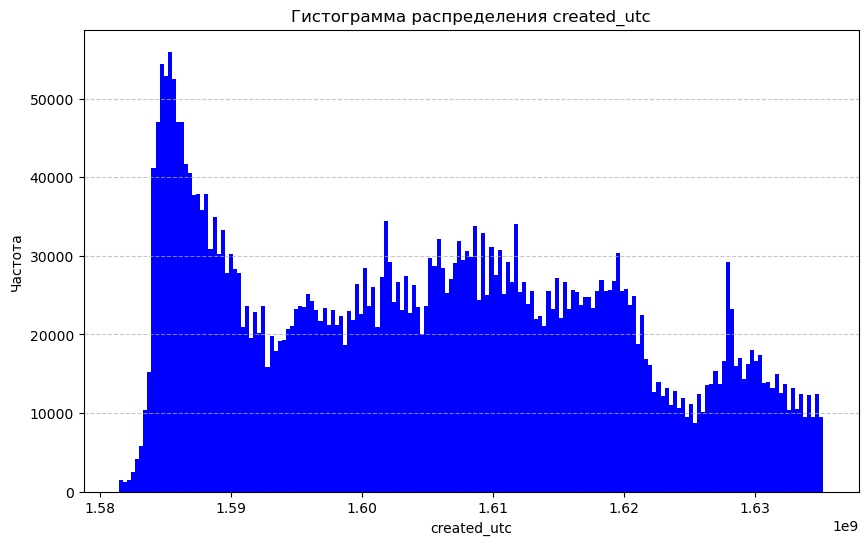

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection - Histogram Visualization") \
    .getOrCreate()

# Загрузка очищенных данных без выбросов
df_cleaned = spark.read.parquet('cleaned_data_no_outliers.parquet')

# Определение колонок
numeric_columns = ['created_utc']

# Преобразование типов колонок в числовые (на случай, если они еще не преобразованы)
for column in numeric_columns:
    df_cleaned = df_cleaned.withColumn(column, col(column).cast("double"))

# Функция для построения гистограммы
def plot_histogram(df, column):
    # Преобразование PySpark DataFrame в Pandas DataFrame для построения графика
    pandas_df = df.select(column).toPandas()
    data = pandas_df[column]
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins='auto', color='blue')
    plt.title(f'Гистограмма распределения {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Построение гистограммы для каждой числовой колонки
for column in numeric_columns:
    plot_histogram(df_cleaned, column)


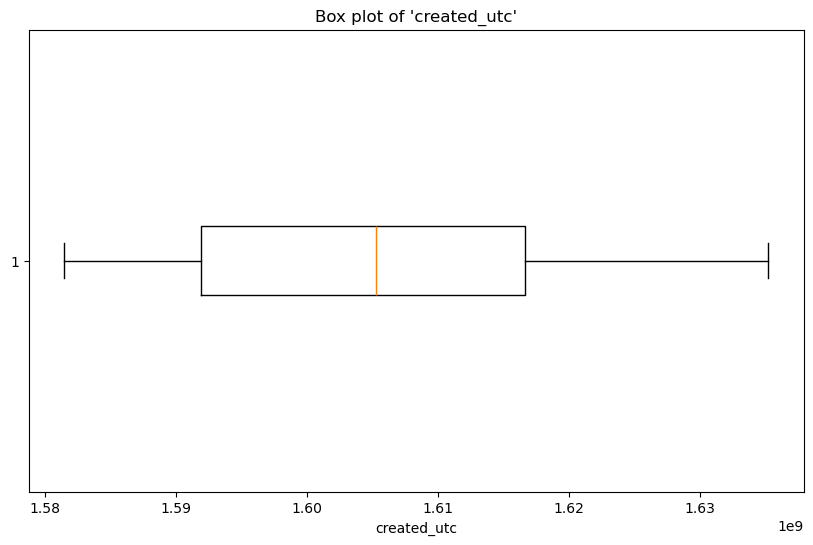

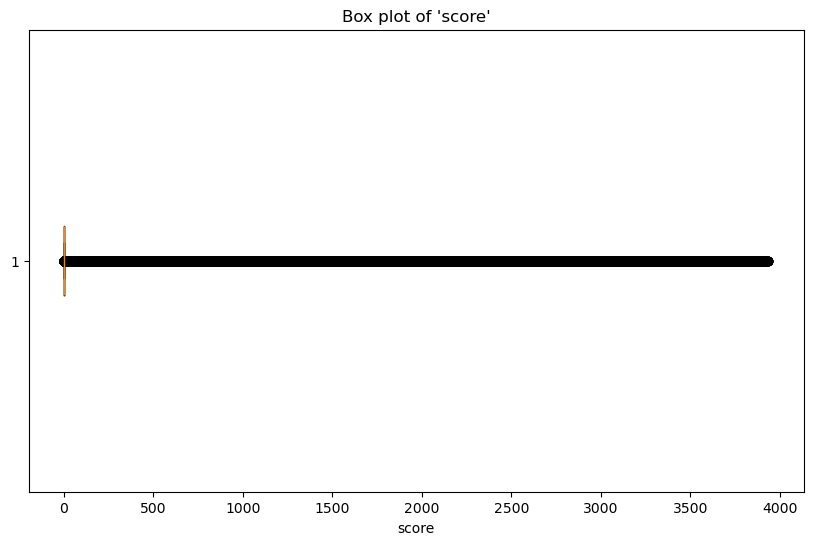

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, percentile_approx, min, max

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection - Box Plot Visualization") \
    .getOrCreate()

# Загрузка очищенных данных без выбросов
df_cleaned = spark.read.parquet('cleaned_data_no_outliers.parquet')

# Определение колонок
numeric_columns = ['created_utc', 'score']

# Преобразование типов колонок в числовые (на случай, если они еще не преобразованы)
for column in numeric_columns:
    df_cleaned = df_cleaned.withColumn(column, col(column).cast("double"))

# Функция для построения box plot
def plot_boxplot(df, column):
    # Вычисление основных статистических показателей с использованием Spark
    stats = df.select(
        percentile_approx(col(column), 0.25).alias('Q1'),
        percentile_approx(col(column), 0.5).alias('Median'),
        percentile_approx(col(column), 0.75).alias('Q3'),
        min(col(column)).alias('Min'),
        max(col(column)).alias('Max')
    ).collect()[0]

    # Извлечение значений
    Q1 = stats['Q1']
    Median = stats['Median']
    Q3 = stats['Q3']
    Min = stats['Min']
    Max = stats['Max']

    # Вычисление межквартильного размаха (IQR)
    IQR = Q3 - Q1

    # Вычисление нижней и верхней границ для выявления выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Преобразование PySpark DataFrame в Pandas DataFrame для дальнейшего анализа
    pandas_df = df.select(column).toPandas()

    # Создание списка выбросов
    outliers = pandas_df[(pandas_df[column] < lower_bound) | (pandas_df[column] > upper_bound)][column].tolist()

    # Создание нового рисунка с заданным размером
    plt.figure(figsize=(10, 6))

    # Построение ящичного графика
    plt.boxplot(pandas_df[column], vert=False)  # vert=False для горизонтального ящика

    # Установка заголовка графика с указанием названия столбца
    plt.title(f"Box plot of '{column}'")
    
    # Установка метки оси x с названием столбца
    plt.xlabel(column)
    
    # Отображение графика
    plt.show()

# Построение box plot для каждой числовой колонки
for column in numeric_columns:
    plot_boxplot(df_cleaned, column)


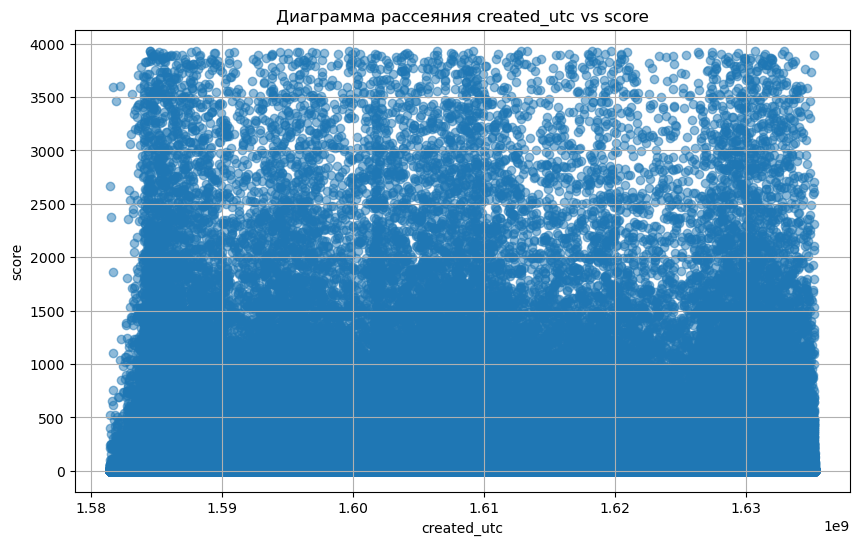

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection - Scatter Plot Visualization") \
    .getOrCreate()

# Загрузка очищенных данных без выбросов
df_cleaned = spark.read.parquet('cleaned_data_no_outliers.parquet')

# Определение колонок
numeric_columns = ['created_utc', 'score']  # Предполагая, что вы хотите построить scatter plot для этих колонок

# Преобразование типов колонок в числовые (на случай, если они еще не преобразованы)
for column in numeric_columns:
    df_cleaned = df_cleaned.withColumn(column, col(column).cast("double"))

# Функция для построения scatter plot
def plot_scatter(df, x_column, y_column):
    # Преобразование PySpark DataFrame в Pandas DataFrame для построения графика
    pandas_df = df.select(x_column, y_column).toPandas()
    x_data = pandas_df[x_column]
    y_data = pandas_df[y_column]
    
    # Построение scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, alpha=0.5)
    plt.title(f'Диаграмма рассеяния {x_column} vs {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.grid(True)
    plt.show()

# Построение scatter plot для пары колонок
plot_scatter(df_cleaned, 'created_utc', 'score')


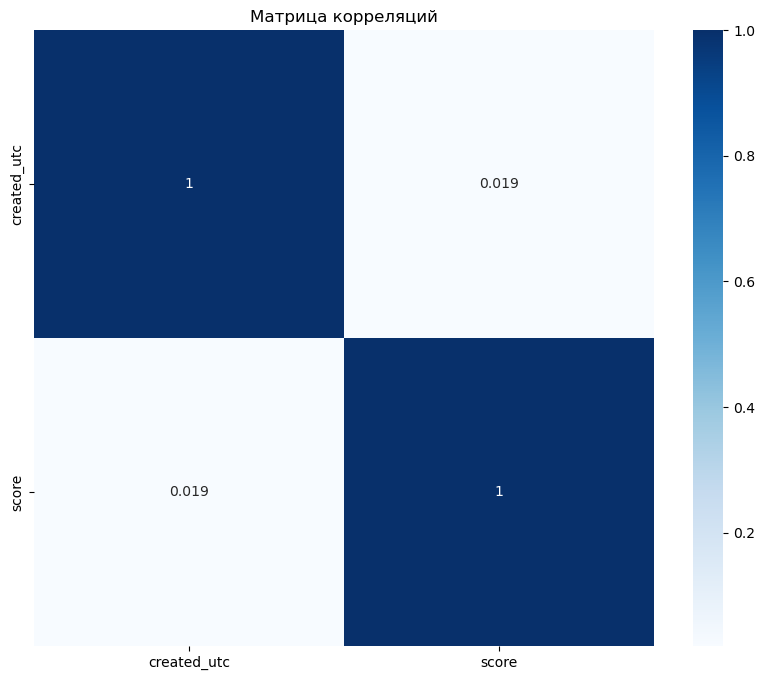

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Инициализация Spark
spark = SparkSession.builder \
    .appName("Anomaly Detection - Correlation Matrix Visualization") \
    .getOrCreate()

# Загрузка очищенных данных без выбросов
df_cleaned = spark.read.parquet('cleaned_data_no_outliers.parquet')

# Определение колонок
numeric_columns = ['created_utc', 'score']

# Преобразование типов колонок в числовые (на случай, если они еще не преобразованы)
for column in numeric_columns:
    df_cleaned = df_cleaned.withColumn(column, col(column).cast("double"))

# Функция для построения матрицы корреляций
def plot_correlation_matrix(df, columns):
    # Использование VectorAssembler для создания вектора признаков
    assembler = VectorAssembler(inputCols=columns, outputCol='features')
    df_vector = assembler.transform(df).select('features')
    
    # Вычисление корреляционной матрицы
    matrix = Correlation.corr(df_vector, 'features').head()[0]
    corr_matrix = matrix.toArray()
    
    # Преобразование корреляционной матрицы в DataFrame Pandas
    corr_df = pd.DataFrame(corr_matrix, index=columns, columns=columns)
    
    # Построение тепловой карты корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, cmap='Blues', xticklabels=corr_df.columns, yticklabels=corr_df.columns)
    plt.title('Матрица корреляций')
    plt.show()

# Построение матрицы корреляций
plot_correlation_matrix(df_cleaned, numeric_columns)
